# Assignment 2: Classification
# Using Machine Learning Tools

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where you are approached by a client to solve a problem.  

The main aims of this assignment are:

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise and clean data;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task, but feel free to add additional cells to structure your notebook. Note that some questions require writing code, some require graphical results, and some require comments or analysis as text. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (**with the correct results displayed**) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code can run correctly on the original data file.

This assignment uses the standard best practice machine learning workflow, building on the first assignment and course workshops, and so less detailed instructions are provided for this assignment. You should be able to implement this workflow now without low-level guidance and a substantial portion of the marks for this assignment are associated with the appropriate choices and executing this workflow correctly and efficiently. Make sure you have clean, readable code as well as producing outputs, since your coding will also count towards the marks (however, excessive commenting is discouraged and will lose marks, so aim for a modest, well-chosen amount of comments and text in outputs).

This assignment can be solved using methods from [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), and [matplotlib](https://matplotlib.org/stable/index.html) as presented in the workshops. Other libraries should not be used (even though they might have nice functionality) and occasionally certain specific functions need to be used, which will be made clear in the instruction text. You are expected to make sure that you are using functions correctly, and you should search and carefully read the documentation if unsure.

# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures most of the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. Their method employs efficient stochastic sampling, making it much faster than existing methods, although slightly noisier. This method does not measure any of the 'worst' features that appear in the *Wisconsin Breast Cancer Data Set*. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 - 1) Have at least a 90% probability of detecting malignant cancer when it is present;
 - 2) Ensure that no more than 1 in 5 healthy cases (those with benign growths) result in a false positive (labeled as malignant).

They have hand-labelled 220 samples for you, with 20 features per sample, which is all they have at the moment.

Please follow the instructions below, which will vary in level of detail.

## 1. Load data, visualise it and identify erroneous values [30%]

 - Load the data from the csv file `assignment2_data_2024.csv` (found on MyUni).
 - Extract the feature names and label names for use later on.
 - Provide at least one text summary of the dataset. This should include key information and characteristics of the data.
 - Create one graphical plot per feature. Each plot must display the feature values for the two classes (malignant and benign) separately on a single axis/panel.
 - Make sure you clearly label the graphical plots with respect to feature names, axes, classes, etc.
 - Identify any erroneous values in the dataset during the data visualisation or summary steps. Determine and implement, here or later, the appropriate action to handle these values (e.g., removal, correction, or none).
 - Throughout this assignment, treat the _malignant_ cases as the _true positive_ class, following the standard convention in medicine.
.

In [1]:
# This code imports some libraries that you will need.
# You should not need to modify it, though you are expected to make other imports later in your code.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time

# Pandas for overview
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

import seaborn as sns

In [2]:
# Your code here

df_cancer_data = pd.read_csv("assignment2_data_2024.csv")

features = list(df_cancer_data.columns[1:])
labels = list(df_cancer_data['label'].unique())

print("feature names:", features)
print("label names:", labels)

feature names: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error']
label names: ['malignant', 'maligant', 'benign']


In [3]:
'''
Correcting the labels because there is one mistyped value 'maligant' instead of 'malignant'.
'''
df_cancer_data.loc[df_cancer_data['label'] == 'maligant', 'label'] = 'malignant'
df_cancer_data['label'].unique()

array(['malignant', 'benign'], dtype=object)

In [4]:
df_cancer_data.head()

,label,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error
0,malignant,15.494653829645529,15.902542,103.008265,776.437239,0.104239,0.168660,0.170572,0.085668,0.205053,...,0.653654,1.096678,4.962255,80.619370,0.006669,0.034950,0.043568,0.013765,0.024093,0.004928
1,malignant,16.229870799611437,18.785613,105.176755,874.712003,0.091843,0.092548,0.081681,0.053670,0.180435,...,0.445451,1.043931,3.005373,50.407958,0.006352,0.019998,0.025324,0.012172,0.018084,0.003582
2,malignant,16.34567074196476,20.114076,107.083804,872.563251,0.099924,0.123799,0.128788,0.078310,0.189756,...,0.549625,1.057447,3.643671,62.732851,0.006757,0.031325,0.034350,0.015150,0.021459,0.004066
3,malignant,13.001009157806651,19.876997,85.889775,541.281012,0.113423,0.173069,0.146214,0.069574,0.212078,...,0.430693,1.202955,3.051434,33.614356,0.007930,0.044881,0.042972,0.014556,0.035670,0.005981
4,malignant,16.416060073302194,17.397533,107.857386,891.516818,0.097321,0.111530,0.125971,0.068575,0.179562,...,0.525532,1.045900,3.747194,59.164555,0.008718,0.024231,0.039763,0.014202,0.019236,0.004115


In [5]:
df_cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    220 non-null    object 
 1   mean radius              220 non-null    object 
 2   mean texture             220 non-null    float64
 3   mean perimeter           220 non-null    float64
 4   mean area                220 non-null    float64
 5   mean smoothness          220 non-null    float64
 6   mean compactness         220 non-null    float64
 7   mean concavity           220 non-null    float64
 8   mean concave points      220 non-null    float64
 9   mean symmetry            220 non-null    float64
 10  mean fractal dimension   220 non-null    float64
 11  radius error             220 non-null    float64
 12  texture error            220 non-null    float64
 13  perimeter error          220 non-null    float64
 14  area error               2

In [6]:
# Extract feature names and label names
feature_names = df_cancer_data.columns[1:]
label_name = df_cancer_data.columns[0]

# Text summary of the dataset
summary = df_cancer_data.describe(include='all')
label_counts = df_cancer_data[label_name].value_counts()

summary_text = f"""
Dataset Summary:
----------------
Number of Instances: {df_cancer_data.shape[0]}
Number of Features: {df_cancer_data.shape[1] - 1}
Class Distribution:
{label_counts.to_string()}

Statistical Summary:
{summary.to_string()}
"""

print(summary_text)



Dataset Summary:
----------------
Number of Instances: 220
Number of Features: 20
Class Distribution:
label
benign       154
malignant     66

Statistical Summary:
         label         mean radius  mean texture  mean perimeter    mean area  mean smoothness  mean compactness  mean concavity  mean concave points  mean symmetry  mean fractal dimension  radius error  texture error  perimeter error  area error  smoothness error  compactness error  concavity error  concave points error  symmetry error  fractal dimension error
count      220                 220    220.000000      220.000000   220.000000       220.000000        220.000000      220.000000           220.000000     220.000000              220.000000    220.000000     220.000000       220.000000  220.000000        220.000000         220.000000       220.000000            220.000000      219.000000               220.000000
unique       2                 220           NaN             NaN          NaN              NaN             

In [7]:
labels = list(df_cancer_data['label'].unique())
labels

['malignant', 'benign']

In [8]:
'''
The `mean radius` feature is an object type column, while it should be numeric. I will first convert it into numeric.
'''
df_cancer_data['mean radius'] = pd.to_numeric(df_cancer_data['mean radius'], errors='coerce')

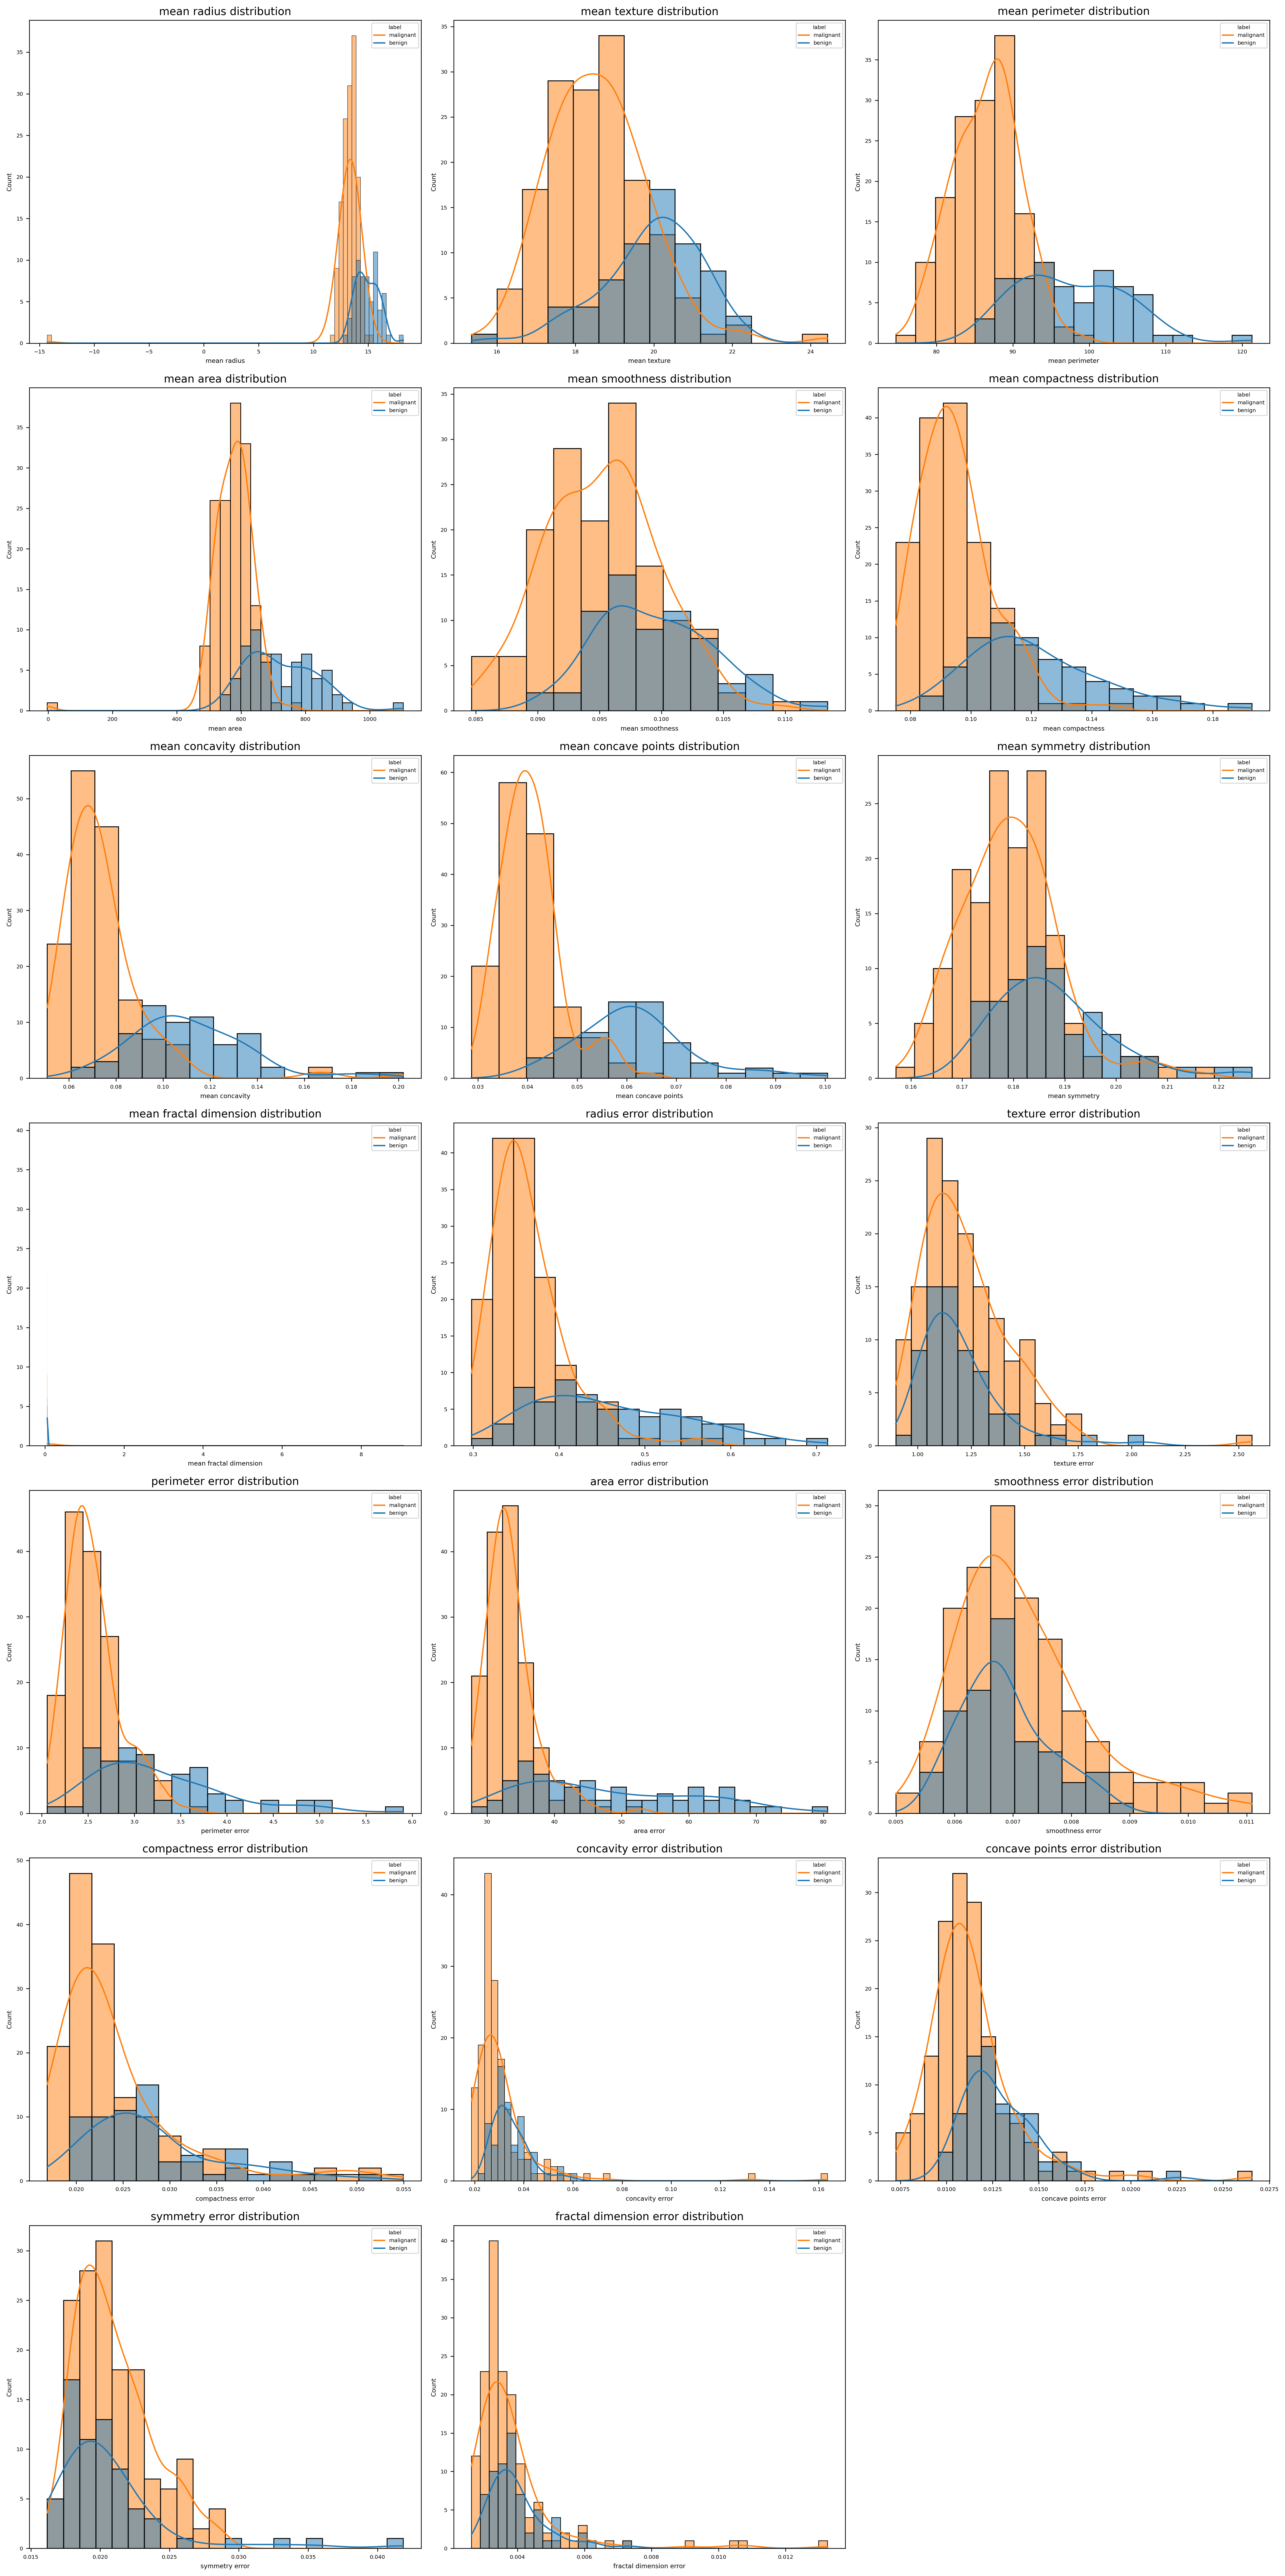

In [9]:
# Graphical plots for each feature
plt.figure(figsize=(20, 40))

for i, feature in enumerate(feature_names):
    plt.subplot(len(feature_names) // 3 + 1, 3, i + 1)
    dx = sns.histplot(data=df_cancer_data, x=feature, hue=label_name, kde=True)
    dx.legend(title=label_name, title_fontsize='6', labels=labels, fontsize='6')
    plt.title(f'{feature} distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## 2. Prepare data and models, and make baseline measurements [20%]
 - Split data into appropriate sets using the `stratify` option to obtain consistent proportions of classes in each set.
 - Decide on appropriate pre-processing steps for the data.
 - Implement a _very_ simple baseline model that makes purely random predictions of the class.
 - Measure the baseline performance with the following metrics:
   - accuracy
   - balanced accuracy: accounts for imblanaced datasets, defined as _(sensitivity + specificity)/2_
   - recall
   - precision
   - auc
   - f1score
   - fbeta_scores with beta=0.1
   - fbeta_score with beta=10
 - Also display a confusion matrix for the baseline predictions.
 - As a second baseline, implement an SGD classifier and fit it once (without hyper-parameter optimisation) and then display the same performance metrics and a confusion matrix for its results.

In [10]:
# Some helpful code that you can use if you wish (or not)

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Ensure plots are displayed inline
%matplotlib inline


f10_scorer = make_scorer(fbeta_score, beta=10,average='macro')
f01_scorer = make_scorer(fbeta_score, beta=0.1,average='macro')

def f10_score(yt,yp):
    return fbeta_score(yt, yp, beta=10,average='macro')

def f01_score(yt,yp):
    return fbeta_score(yt, yp, beta=0.1,average='macro')

In [11]:
# Check class distribution
from sklearn.utils import resample

# # Ensure the correct column name for the label
# label_name = 'label'  # Replace with the actual label column name if different

# # Check if the label column exists
# if label_name not in df_cancer_data.columns:
#     raise KeyError(f"'{label_name}' column not found in the dataset. Available columns are: {list(df_cancer_data.columns)}")

# # Extract feature names and label names
# feature_names = df_cancer_data.columns[df_cancer_data.columns != label_name]

# Identify and clean non-numeric values in each column

# Ensure the correct column name for the label
label_col = 'label'  # Replace with the actual label column name if different

# Check if the label column exists
if label_col not in df_cancer_data.columns:
    raise KeyError(f"'{label_col}' column not found in the dataset. Available columns are: {list(df_cancer_data.columns)}")

# Extract feature names and label names
feature_names = df_cancer_data.columns[df_cancer_data.columns != label_col]

class_counts = df_cancer_data[label_name].value_counts()
print(class_counts)

# Handle imbalanced data by upsampling minority classes
majority_class = df_cancer_data[df_cancer_data[label_name] == class_counts.idxmax()]
minority_classes = df_cancer_data[df_cancer_data[label_name] != class_counts.idxmax()]

# Upsample minority classes
minority_upsampled = resample(minority_classes, 
                              replace=True,    # sample with replacement
                              n_samples=len(majority_class),  # to match majority class
                              random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
df_balanced = pd.concat([majority_class, minority_upsampled])

# Display new class counts
print(df_balanced[label_name].value_counts())



label
benign       154
malignant     66
Name: count, dtype: int64
label
benign       154
malignant    154
Name: count, dtype: int64


In [12]:
# Identify categorical and numeric columns
categorical_cols = df_balanced.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df_balanced.select_dtypes(include=['number']).columns.tolist()

# Remove the label column from the feature lists if present
if label_col in categorical_cols:
    categorical_cols.remove(label_col)
if label_col in numeric_cols:
    numeric_cols.remove(label_col)

# Separate features and target variable
X_balanced = df_balanced[feature_names]
y_balanced = df_balanced[label_col]

# Verify columns
print("Categorical Columns:", categorical_cols)
print("Numeric Columns:", numeric_cols)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

Categorical Columns: []
Numeric Columns: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error']


In [13]:
# Preprocess numeric features
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

try:
    # Transform numeric features
    X_train_numeric = numeric_transformer.fit_transform(X_train[numeric_cols])
    X_test_numeric = numeric_transformer.transform(X_test[numeric_cols])

except KeyError as e:
    print(f"Error in processing columns: {e}")
    print(f"Available columns in X_train: {list(X_train.columns)}")
    print(f"Available columns in X_test: {list(X_test.columns)}")
    raise

In [14]:
X_train_transformed = X_train_numeric
X_test_transformed = X_test_numeric

In [15]:
X_train_transformed.shape, X_test_transformed.shape

((246, 20), (62, 20))

In [16]:
'''Encoding target variable as it is string type'''
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [17]:
y_train.shape, y_test.shape

((246,), (62,))

Baseline Model Performance Metrics:
Accuracy: 0.41935483870967744
Balanced Accuracy: 0.41935483870967744
Recall: 0.41935483870967744
Precision: 0.41935483870967744
AUC: 0.41935483870967744
F1 Score: 0.41935483870967744
F-beta Score (beta=0.1): 0.41935483870967744
F-beta Score (beta=10): 0.41935483870967744



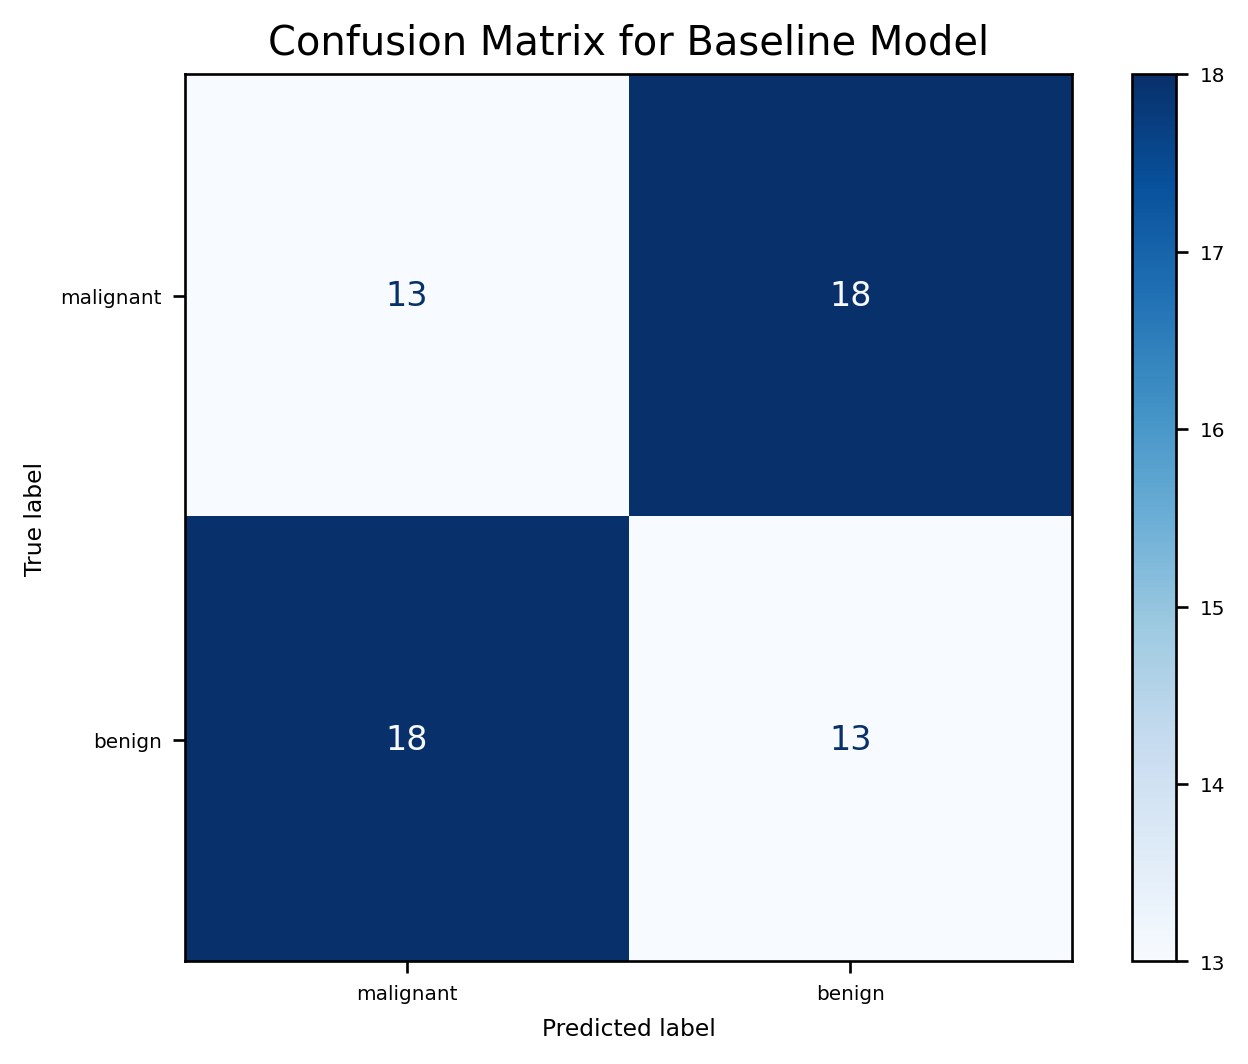

In [18]:
# Implement a simple baseline model
baseline_clf = DummyClassifier(strategy="uniform", random_state=42)
baseline_clf.fit(X_train_transformed, y_train)
baseline_pred = baseline_clf.predict(X_test_transformed)

# Calculate the required metrics for the baseline model with appropriate average
accuracy = accuracy_score(y_test, baseline_pred)
balanced_acc = balanced_accuracy_score(y_test, baseline_pred)
recall = recall_score(y_test, baseline_pred, average='macro')
precision = precision_score(y_test, baseline_pred, average='macro')
auc = roc_auc_score(y_test, baseline_pred, multi_class='ovr')
f1 = f1_score(y_test, baseline_pred, average='macro')
fbeta_0_1 = f01_score(y_test, baseline_pred)
fbeta_10 = f10_score(y_test, baseline_pred)

print(f"Baseline Model Performance Metrics:\n"
      f"Accuracy: {accuracy}\n"
      f"Balanced Accuracy: {balanced_acc}\n"
      f"Recall: {recall}\n"
      f"Precision: {precision}\n"
      f"AUC: {auc}\n"
      f"F1 Score: {f1}\n"
      f"F-beta Score (beta=0.1): {fbeta_0_1}\n"
      f"F-beta Score (beta=10): {fbeta_10}\n")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, baseline_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df_cancer_data[label_col].unique())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Baseline Model')
plt.show()

SGD Classifier Performance Metrics:
Accuracy: 0.967741935483871
Balanced Accuracy: 0.967741935483871
Recall: 0.967741935483871
Precision: 0.9696969696969697
AUC: 0.002081165452653484
F1 Score: 0.9677083333333334
F-beta Score (beta=0.1): 0.9696378048052264
F-beta Score (beta=10): 0.967721724746426



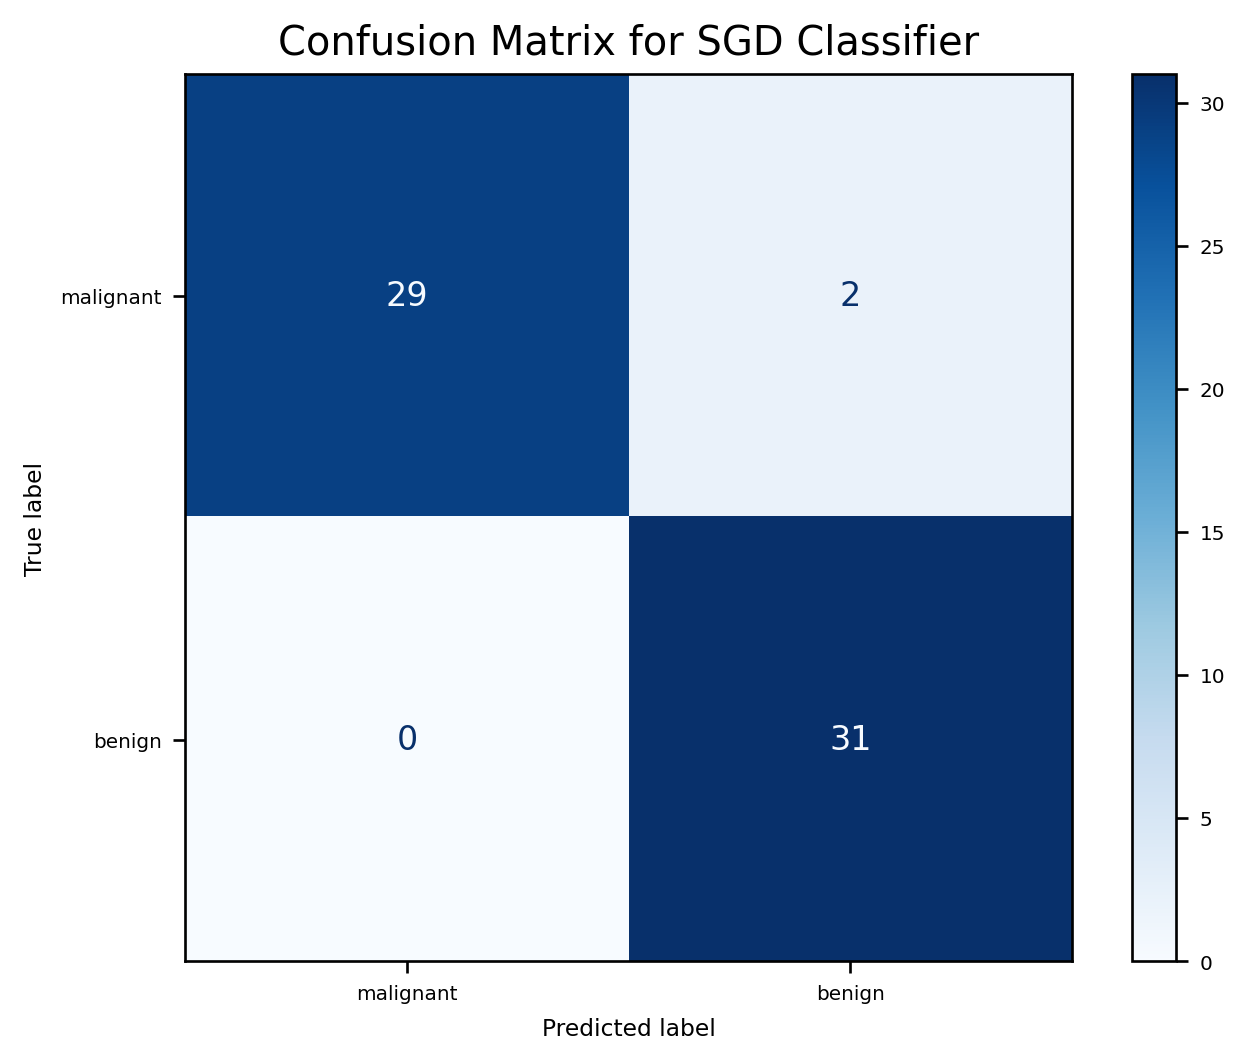

In [19]:
# Implement an SGD classifier with calibration
from sklearn.calibration import CalibratedClassifierCV

sgd_clf = SGDClassifier(random_state=42)
calibrated_sgd_clf = CalibratedClassifierCV(sgd_clf, method='sigmoid')
calibrated_sgd_clf.fit(X_train_transformed, y_train)
sgd_pred = calibrated_sgd_clf.predict(X_test_transformed)
sgd_proba = calibrated_sgd_clf.predict_proba(X_test_transformed)

# Calculate metrics for the SGD classifier with appropriate average
sgd_accuracy = accuracy_score(y_test, sgd_pred)
sgd_balanced_acc = balanced_accuracy_score(y_test, sgd_pred)
sgd_recall = recall_score(y_test, sgd_pred, average='macro')
sgd_precision = precision_score(y_test, sgd_pred, average='macro')
sgd_auc = roc_auc_score(y_test, sgd_proba[:, 0], multi_class='ovr')
sgd_f1 = f1_score(y_test, sgd_pred, average='macro')
sgd_fbeta_0_1 = fbeta_score(y_test, sgd_pred, beta=0.1, average='macro')
sgd_fbeta_10 = fbeta_score(y_test, sgd_pred, beta=10, average='macro')

print(f"SGD Classifier Performance Metrics:\n"
      f"Accuracy: {sgd_accuracy}\n"
      f"Balanced Accuracy: {sgd_balanced_acc}\n"
      f"Recall: {sgd_recall}\n"
      f"Precision: {sgd_precision}\n"
      f"AUC: {sgd_auc}\n"
      f"F1 Score: {sgd_f1}\n"
      f"F-beta Score (beta=0.1): {sgd_fbeta_0_1}\n"
      f"F-beta Score (beta=10): {sgd_fbeta_10}\n")

# Confusion matrix for SGD classifier
sgd_conf_matrix = confusion_matrix(y_test, sgd_pred)
sgd_disp = ConfusionMatrixDisplay(confusion_matrix=sgd_conf_matrix, display_labels=df_cancer_data[label_col].unique())
sgd_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SGD Classifier')
plt.show()

## 3. Model Optimisation [40%]

### 3.1 Performance metric
Choose one performance metric from the above set. State your choice and explain why you chose it. [50 words maximum]

In [20]:
# Answer here
'''
Since the client is interested in at least a 90% probability of detecting malignant cancer
when it is present, this translates to a recall score of 0.9.
'''

'\nSince the client is interested in at least a 90% probability of detecting malignant cancer\nwhen it is present, this translates to a recall score of 0.9.\n'

### 3.2 Hyper-parameter optimisation
 - Perform a hyper-parameter optimisation (using appropriate methods) on three models:
   - SGD Classifer
   - SVM
   - One other model of your choice
 - Display the results of each model (including confusion matrices) and choose the best model.
 - Choose the best model and display the final results of this model.

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

# Define hyper-parameter grids
sgd_param_grid = {
    'loss': ['log_loss'],  # 'log_loss' is the correct value
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 1500, 2000]
}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Create GridSearchCV objects for each model
sgd_clf = SGDClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)

sgd_grid_search = GridSearchCV(sgd_clf, sgd_param_grid, scoring='balanced_accuracy', cv=5, n_jobs=12)
svm_grid_search = GridSearchCV(svm_clf, svm_param_grid, scoring='balanced_accuracy', cv=5, n_jobs=12)
gb_grid_search = GridSearchCV(gb_clf, gb_param_grid, scoring='balanced_accuracy', cv=5, n_jobs=12)

In [22]:
# Fit the models
sgd_grid_search.fit(X_train_transformed, y_train)
svm_grid_search.fit(X_train_transformed, y_train)
gb_grid_search.fit(X_train_transformed, y_train)

# Get the best models
best_sgd = sgd_grid_search.best_estimator_
best_svm = svm_grid_search.best_estimator_
best_gb = gb_grid_search.best_estimator_

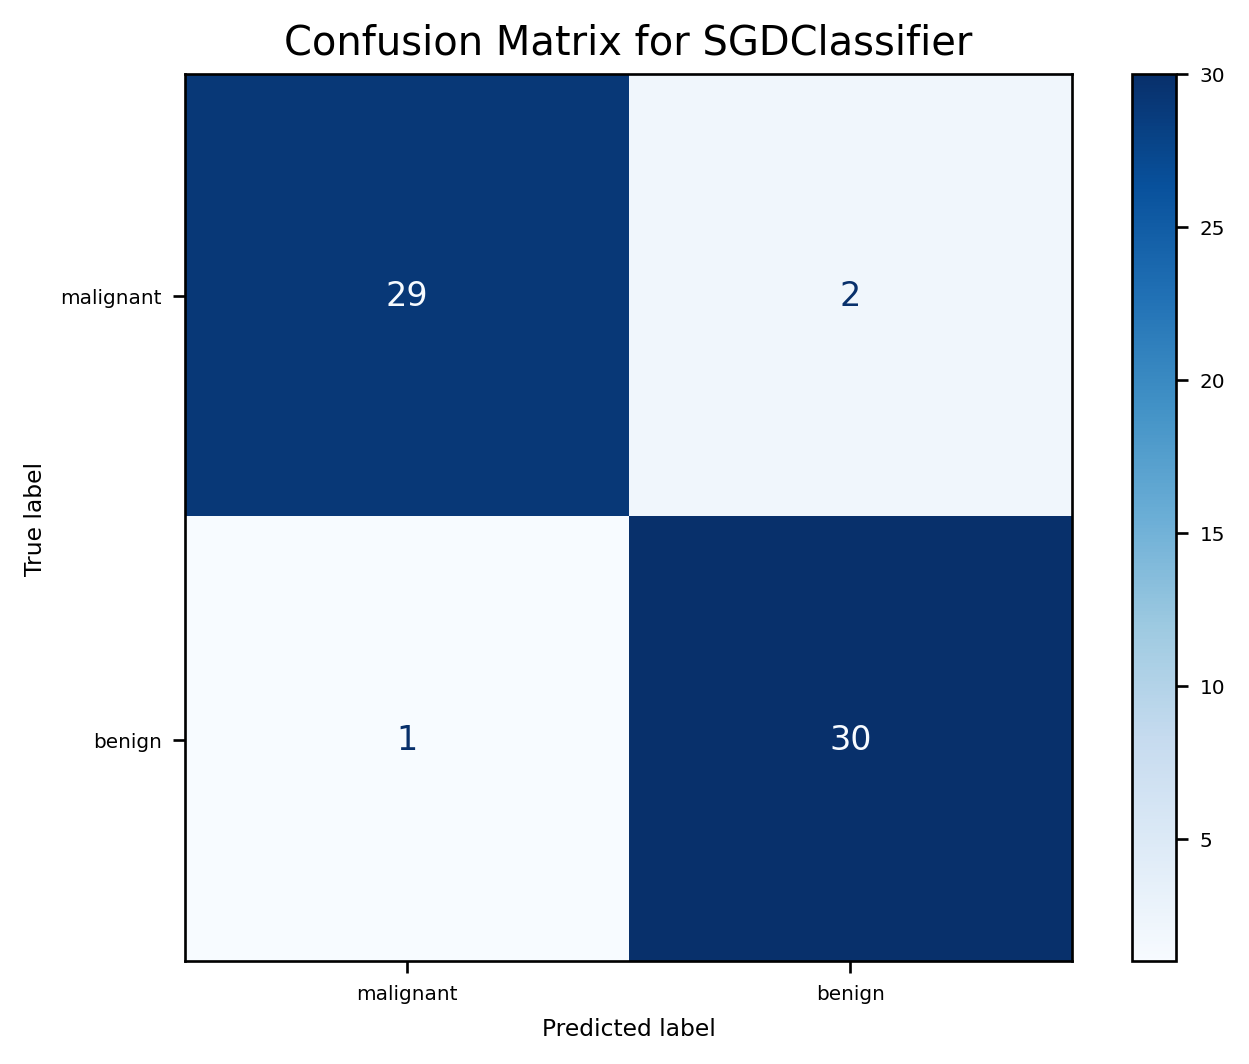

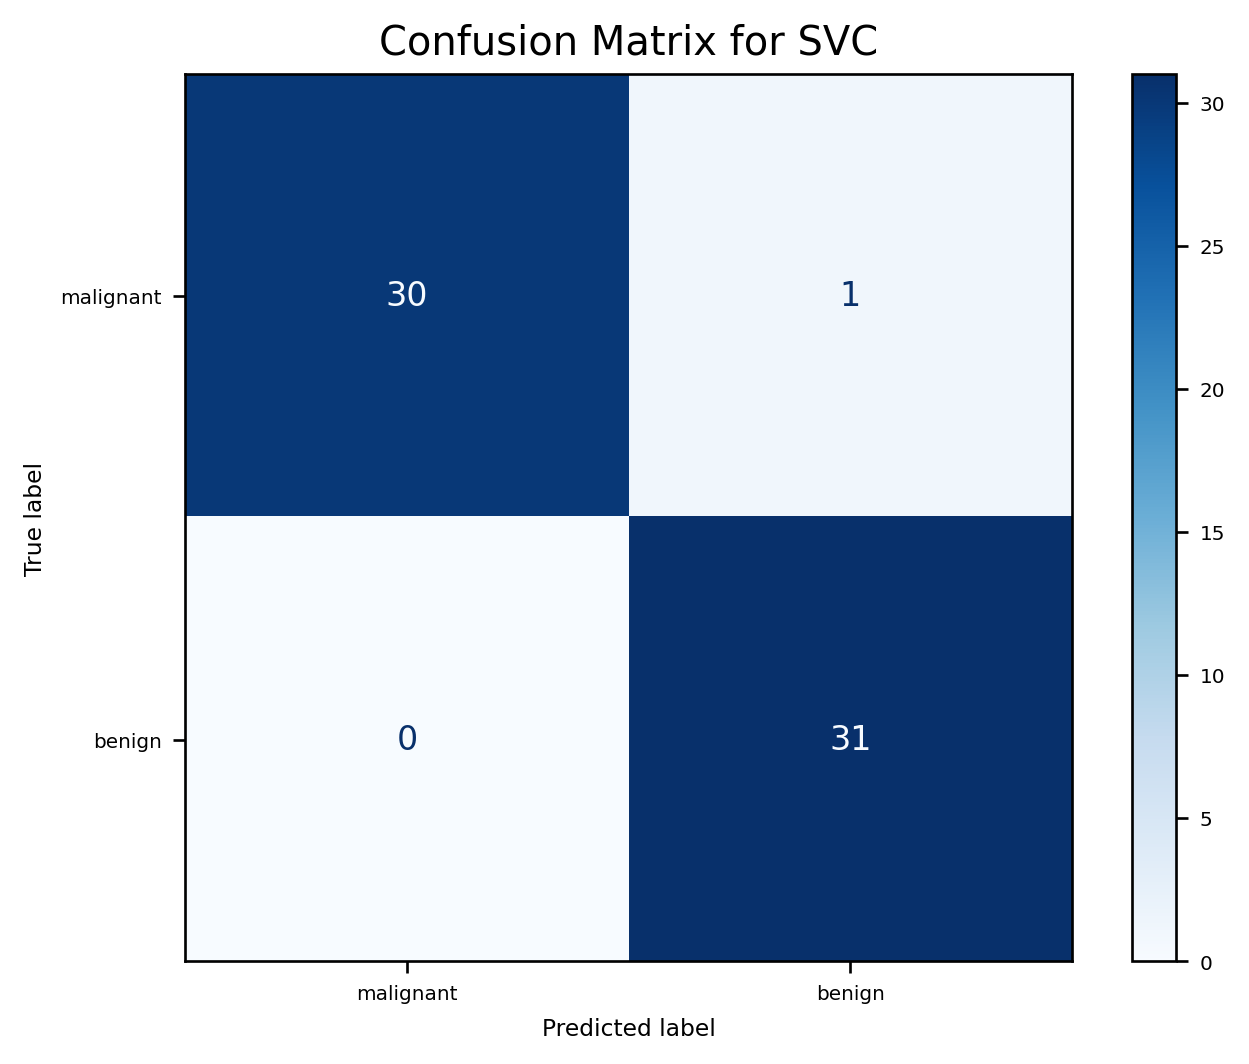

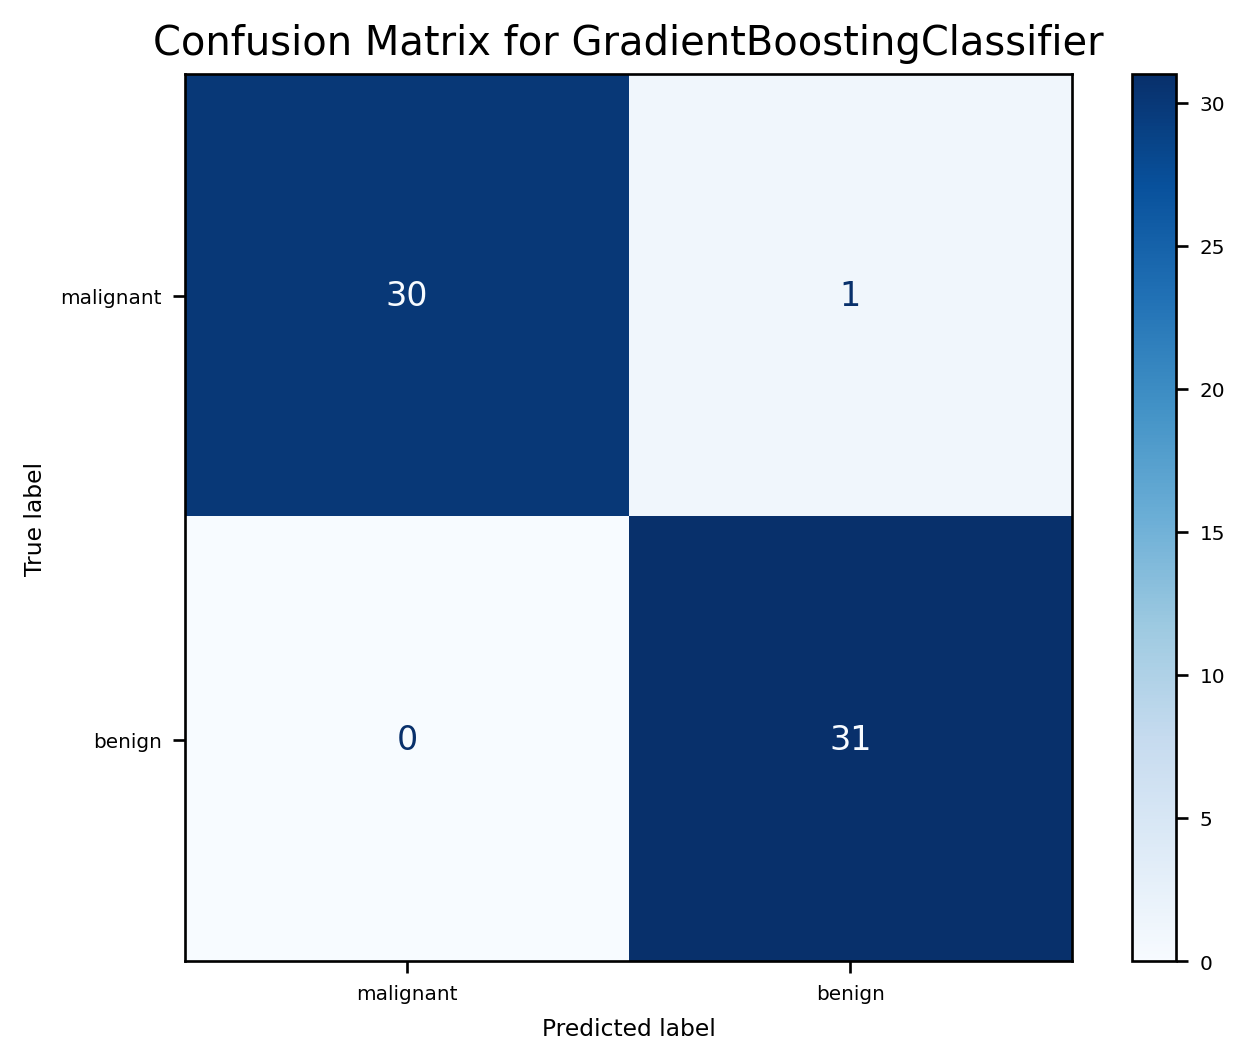

SGD Results: {'accuracy': 0.9516129032258065, 'balanced_accuracy': 0.9516129032258065, 'recall': 0.967741935483871, 'precision': 0.9520833333333334, 'auc': 0.9516129032258066, 'f1_score': 0.9523809523809523, 'fbeta_0_1': 0.9520689489328318, 'fbeta_10': 0.9516078488977023}
SVM Results: {'accuracy': 0.9838709677419355, 'balanced_accuracy': 0.9838709677419355, 'recall': 1.0, 'precision': 0.984375, 'auc': 0.9838709677419355, 'f1_score': 0.9841269841269841, 'fbeta_0_1': 0.9843599528283054, 'fbeta_10': 0.9838659167044096}
GB Results: {'accuracy': 0.9838709677419355, 'balanced_accuracy': 0.9838709677419355, 'recall': 1.0, 'precision': 0.984375, 'auc': 0.9838709677419355, 'f1_score': 0.9841269841269841, 'fbeta_0_1': 0.9843599528283054, 'fbeta_10': 0.9838659167044096}


In [23]:

# Predict and evaluate each model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fbeta_0_1 = fbeta_score(y_test, y_pred, beta=0.1, average='macro')
    fbeta_10 = fbeta_score(y_test, y_pred, beta=10, average='macro')
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df_cancer_data[label_col].unique())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'recall': recall,
        'precision': precision,
        'auc': auc,
        'f1_score': f1,
        'fbeta_0_1': fbeta_0_1,
        'fbeta_10': fbeta_10
    }

# Evaluate models
sgd_results = evaluate_model(best_sgd, X_test_transformed, y_test)
svm_results = evaluate_model(best_svm, X_test_transformed, y_test)
gb_results = evaluate_model(best_gb, X_test_transformed, y_test)

print("SGD Results:", sgd_results)
print("SVM Results:", svm_results)
print("GB Results:", gb_results)

Best Model: SVC
Best Results: {'accuracy': 0.9838709677419355, 'balanced_accuracy': 0.9838709677419355, 'recall': 1.0, 'precision': 0.984375, 'auc': 0.9838709677419355, 'f1_score': 0.9841269841269841, 'fbeta_0_1': 0.9843599528283054, 'fbeta_10': 0.9838659167044096}


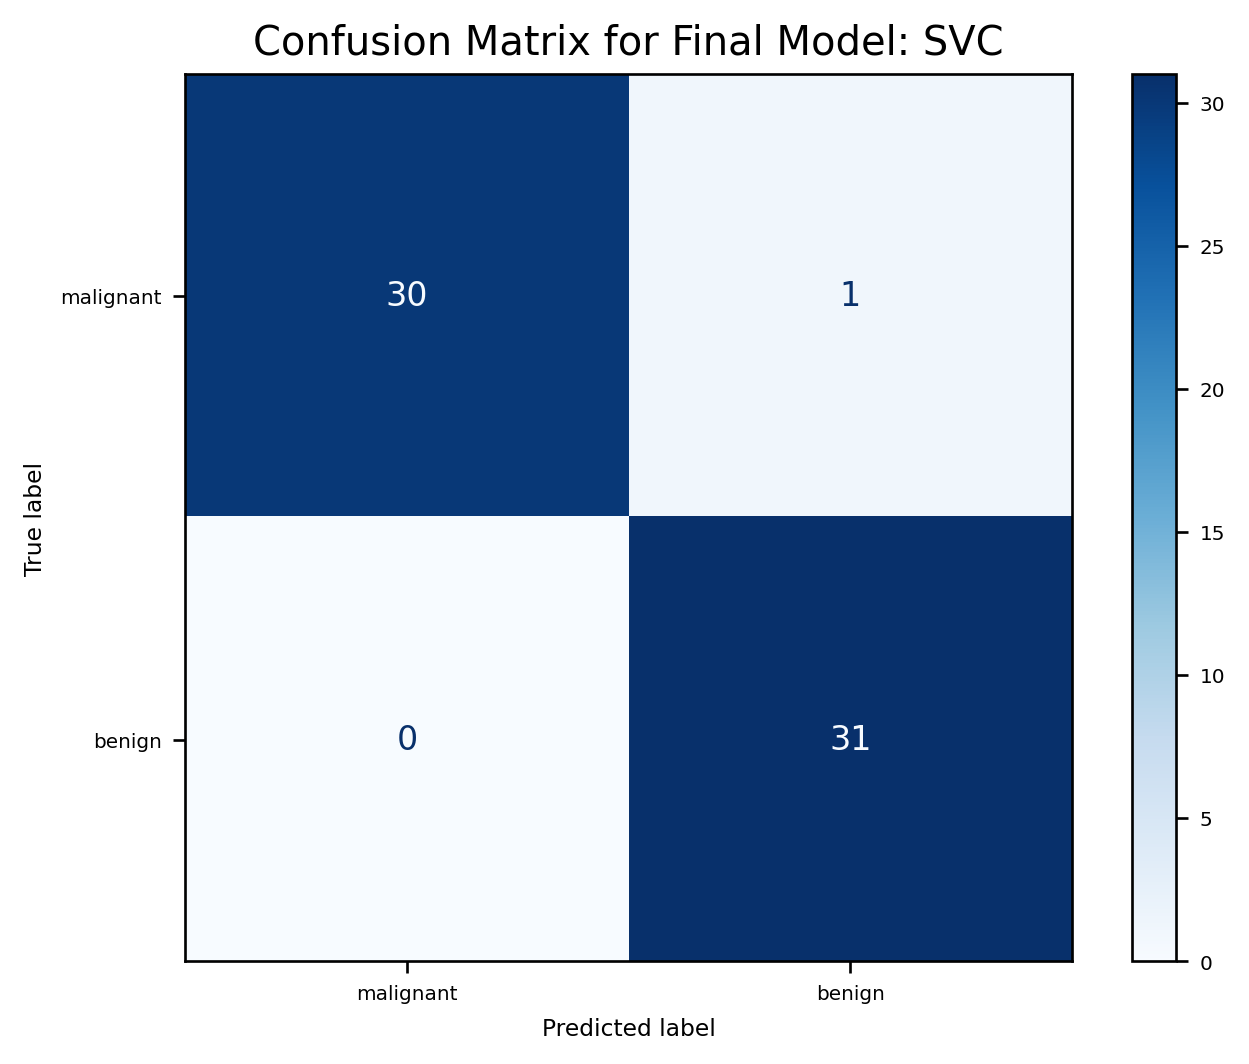

Final Model Results: {'accuracy': 0.9838709677419355, 'balanced_accuracy': 0.9838709677419355, 'recall': 0.9838709677419355, 'precision': 0.984375, 'auc': 0.9838709677419355, 'f1_score': 0.9838667707520166, 'fbeta_0_1': 0.9843599528283054, 'fbeta_10': 0.9838659167044096}


In [24]:
# Choose the best model
best_model, best_results = None, None
if sgd_results['balanced_accuracy'] >= svm_results['balanced_accuracy'] and sgd_results['balanced_accuracy'] >= gb_results['balanced_accuracy']:
    best_model = best_sgd
    best_results = sgd_results
elif svm_results['balanced_accuracy'] >= sgd_results['balanced_accuracy'] and svm_results['balanced_accuracy'] >= gb_results['balanced_accuracy']:
    best_model = best_svm
    best_results = svm_results
else:
    best_model = best_gb
    best_results = gb_results

print(f"Best Model: {best_model.__class__.__name__}")
print("Best Results:", best_results)

# Display final results of the best model
final_model = best_model.fit(X_train_transformed, y_train)
final_pred = final_model.predict(X_test_transformed)
final_proba = final_model.predict_proba(X_test_transformed)

final_conf_matrix = confusion_matrix(y_test, final_pred)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_conf_matrix, display_labels=df_cancer_data[label_col].unique())
final_disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Final Model: {best_model.__class__.__name__}')
plt.show()

final_results = {
    'accuracy': accuracy_score(y_test, final_pred),
    'balanced_accuracy': balanced_accuracy_score(y_test, final_pred),
    'recall': recall_score(y_test, final_pred, average='macro'),
    'precision': precision_score(y_test, final_pred, average='macro'),
    'auc': roc_auc_score(y_test, final_pred, multi_class='ovr'),
    'f1_score': f1_score(y_test, final_pred, average='macro'),
    'fbeta_0_1': fbeta_score(y_test, final_pred, beta=0.1, average='macro'),
    'fbeta_10': fbeta_score(y_test, final_pred, beta=10, average='macro')
}

print("Final Model Results:", final_results)

### 3.3 Final results

From the final results calculate the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer.

In [25]:
# Answer here

import numpy as np

# Assuming 'malignant' is the class indicating cancer and 'benign' is the class indicating no cancer
# We need to replace 'malignant' and 'benign' with the actual labels used in your dataset
malignant_label = 'malignant'  # Change this to the actual label for malignant tumors
benign_label = 'benign'  # Change this to the actual label for benign cases

# Get the index of the malignant class
malignant_index = list(df_cancer_data[label_col].unique()).index(malignant_label)
benign_index = list(df_cancer_data[label_col].unique()).index(benign_label)

# Extract values from the confusion matrix
false_negatives = final_conf_matrix[malignant_index, benign_index]
true_positives = final_conf_matrix[malignant_index, malignant_index]

# Calculate the probability of a false negative (malignant tumor classified as benign)
probability_false_negative = false_negatives / (false_negatives + true_positives)

print(f"Probability of a false negative for a malignant tumor: {probability_false_negative:.4f}")

Probability of a false negative for a malignant tumor: 0.0323


## 4. Decision Boundaries [10%]
 - To finish up, the client wants a visualisation of how the final model is working and your line manager has asked you to show some of the decision boundaries.
 - The client also wants to know if your method has met their performance specifications.
 - Follow the next three steps (4.1, 4.2 and 4.3) to do these things.

### 4.1 Discriminative features

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

The formula for the T-score is:

_(mean(x2) - mean(x1))/(0.5*(stddev(x2) + stddev(x1)))_

where x1 and x2 are the feature values corresponding to the two classes. Large values for the T-score (either positive or negative) indicate discriminative ability.

**Calculate the T-score for each feature and print out the best 4 features according to this score.**

In [26]:
import numpy as np

# Assuming 'malignant' is the class indicating cancer and 'benign' is the class indicating no cancer
malignant_label = 'malignant'  # Change this to the actual label for malignant tumors
benign_label = 'benign'  # Change this to the actual label for benign cases

# Ensure all feature columns are numeric
for feature in df_balanced.columns:
    if feature != label_col:
        df_balanced[feature] = pd.to_numeric(df_balanced[feature], errors='coerce')

# Drop any rows with NaN values that may have been introduced by coercing to numeric
df_balanced.dropna(inplace=True)

# Separate the dataset into two classes
class_1 = df_balanced[df_balanced[label_col] == malignant_label]
class_2 = df_balanced[df_balanced[label_col] == benign_label]

# Calculate the T-score for each feature
t_scores = {}
for feature in feature_names:
    if pd.api.types.is_numeric_dtype(df_balanced[feature]):
        mean_1 = class_1[feature].mean()
        mean_2 = class_2[feature].mean()
        stddev_1 = class_1[feature].std()
        stddev_2 = class_2[feature].std()
        
        if stddev_1 + stddev_2 != 0:  # Avoid division by zero
            t_score = (mean_2 - mean_1) / (0.5 * (stddev_2 + stddev_1))
            t_scores[feature] = abs(t_score)
        else:
            t_scores[feature] = 0  # If both stddev are zero, t-score is set to 0

# Sort features by T-score in descending order
sorted_t_scores = sorted(t_scores.items(), key=lambda item: item[1], reverse=True)

# Print the best 4 features according to the T-score
top_4_features = sorted_t_scores[:4]
print("Top 4 discriminative features based on T-score:")
for feature, score in top_4_features:
    print(f"{feature}: {score:.4f}")

Top 4 discriminative features based on T-score:
mean concave points: 2.4309
mean perimeter: 2.0544
mean area: 1.7351
mean concavity: 1.6882


In [27]:
# import numpy as np

# # Assuming 'malignant' is the class indicating cancer and 'benign' is the class indicating no cancer
# malignant_label = 'malignant'  # Change this to the actual label for malignant tumors
# benign_label = 'benign'  # Change this to the actual label for benign cases

# # Separate the dataset into two classes
# class_1 = df_balanced[df_balanced[label_col] == malignant_label]
# class_2 = df_balanced[df_balanced[label_col] == benign_label]

# # Calculate the T-score for each feature
# t_scores = {}
# for feature in feature_names:
#     # Ensure the feature values are numeric and handle non-numeric cases
#     if pd.api.types.is_numeric_dtype(df_balanced[feature]):
#         mean_1 = class_1[feature].mean()
#         mean_2 = class_2[feature].mean()
#         stddev_1 = class_1[feature].std()
#         stddev_2 = class_2[feature].std()

#         if stddev_1 + stddev_2 != 0:  # Avoid division by zero
#             t_score = (mean_2 - mean_1) / (0.5 * (stddev_2 + stddev_1))
#             t_scores[feature] = abs(t_score)
#         else:
#             t_scores[feature] = 0  # If both stddev are zero, t-score is set to 0

# # Sort features by T-score in descending order
# sorted_t_scores = sorted(t_scores.items(), key=lambda item: item[1], reverse=True)

# # Print the best 4 features according to the T-score
# top_4_features = sorted_t_scores[:4]
# print("Top 4 discriminative features based on T-score:")
# for feature, score in top_4_features:
#     print(f"{feature}: {score:.4f}")


### 4.2 Visualise decision boundaries

**Display the decision boundaries** for each pair of features from the best 4 chosen above.  You can use the functions below to help if you like.

Instead of using the simple mean as the input for `xmean` in `plot_contours`, use the following:

_0.5*(mean(x1) + mean(x2))_

where x1 and x2 are the data associated with the two classes.  This way of calculating a "mean" point takes into account any imbalance between the classes.

In [28]:
def make_meshgrid(x, y, ns=100):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on (only min and max used)
    y: data to base y-axis meshgrid on (only min and max used)
    ns: number of steps in grid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.max(), y.min()
    hx = (x_max - x_min)/ns
    hy = (y_max - y_min)/ns
    xx, yy = np.meshgrid(np.arange(x_min, x_max + hx, hx), np.arange(y_min, y_max + hy, hy))
    return xx, yy

In [29]:

def plot_contours(clf, xx, yy, xmean, n1, n2, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    xmean : 1d array of N mean values (used to populate constant features with)
    n1, n2: index numbers of features that change
              that is, which features xx and yy represent, from the set of N features
    params: dictionary of params to pass to contourf, optional
    """
    # The following lines make an MxN matrix to pass to the classifier (# samples x # features)
    # It does this by multiplying Mx1 and 1xN matrices, where the former is filled with 1's
    #  where M is the number of grid points in xx and N is the number of features in xmean
    #  It is done in such a way that the xmean vector is replaced in each row
    fullx = np.ones((xx.ravel().shape[0], 1)) * np.reshape(xmean, (1, -1))
    fullx[:, n1] = xx.ravel()
    fullx[:, n2] = yy.ravel()
    Z = clf.predict(fullx)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out



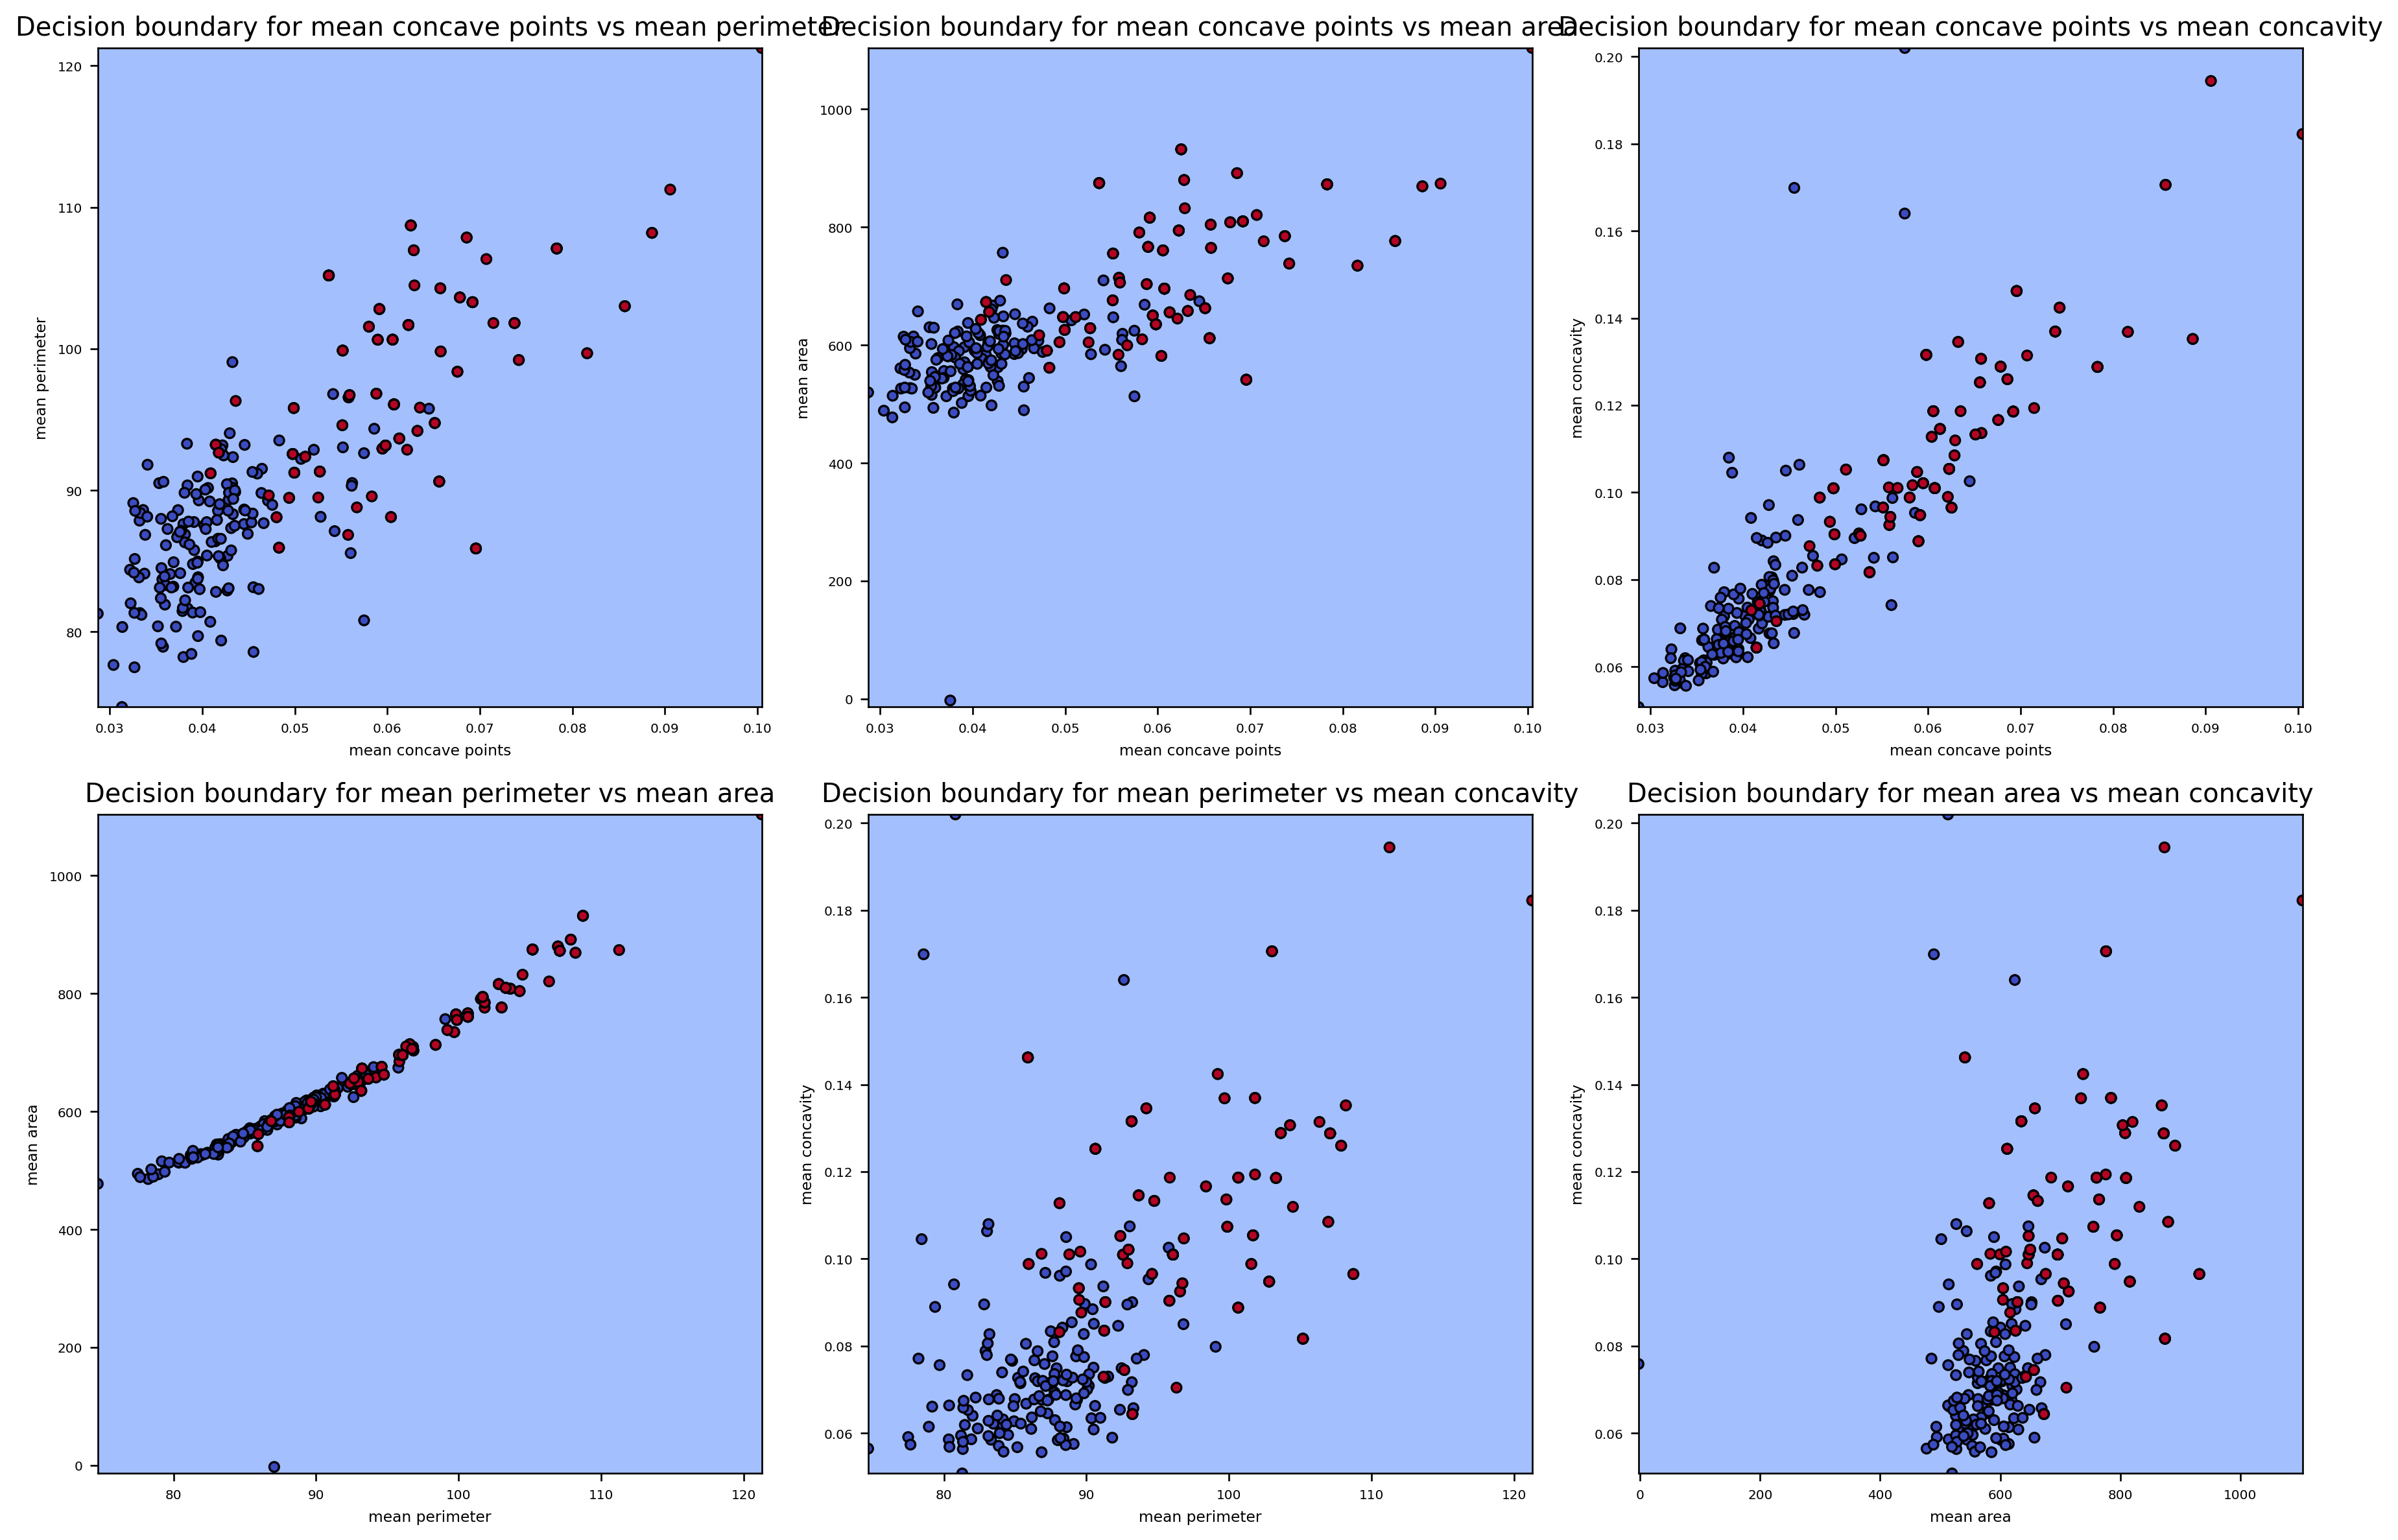

In [30]:

# Use the best model from the previous section (assuming 'best_model' and 'final_model' are available)
best_model = final_model

# Calculate the class-specific mean points
numeric_cols = df_balanced.select_dtypes(include=[np.number]).columns

class_1_mean = df_balanced[df_balanced[label_col] == class_counts.idxmax()][numeric_cols].mean()
class_2_mean = df_balanced[df_balanced[label_col] != class_counts.idxmax()][numeric_cols].mean()
xmean = 0.5 * (class_1_mean + class_2_mean)

# Map labels to numeric values
label_mapping = {'benign': 0, 'malignant': 1}
df_balanced['label_numeric'] = df_balanced[label_col].map(label_mapping)

# Plot decision boundaries for each pair of the top 4 features
plt.figure(figsize=(15, 10))
plot_num = 1
top_4_feature_names = [feature[0] for feature in top_4_features]
ax = None
for i in range(len(top_4_features)):
    for j in range(i + 1, len(top_4_features)):
        feature1 = top_4_features[i][0]
        feature2 = top_4_features[j][0]
        
        X_pair = df_balanced[[feature1, feature2]].values
        y_pair = df_balanced['label_numeric'].values
        
        xx, yy = make_meshgrid(X_pair[:, 0], X_pair[:, 1])
        
        ax = plt.subplot(2, 3, plot_num)
        plot_contours(best_model, xx, yy, xmean.values, top_4_feature_names.index(feature1), top_4_feature_names.index(feature2), cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(df_balanced[feature1], df_balanced[feature2], c=df_balanced['label_numeric'], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel(feature1)
        ax.set_ylabel(feature2)
        ax.set_title(f"Decision boundary for {feature1} vs {feature2}")
        
        plot_num += 1

plt.tight_layout()
plt.show()


### 4.3 Performance specification
**Does the final model meet the client's criteria?  Explain why or why not.** [100 words maximum]

In [38]:
# Answer here
print(f'''
Our best model is `SVC(C=10, probability=True, random_state=42)` with the following final scores:
Precision = {final_results['precision']}
Recall = {final_results['recall']}
False Negative Rate = {probability_false_negative}

These criteria do indeed fall within the client's requirements of at least 90% probability of detecting malignant cancer when it is present, as well as an FPR of less than 20%
Moreover, the decision boundaries for the top 4 discriminative features show clear separation between the two classes, aiding to client's requirements of interpretability (as they wanted to see how the model works).''')


Our best model is `SVC(C=10, probability=True, random_state=42)` with the following final scores:
Precision = 0.984375
Recall = 0.9838709677419355
False Negative Rate = 0.03225806451612903

These criteria do indeed fall within the client's requirements of at least 90% probability of detecting malignant cancer when it is present, as well as an FPR of less than 20%
Moreover, the decision boundaries for the top 4 discriminative features show clear separation between the two classes, aiding to client's requirements of interpretability (as they wanted to see how the model works).
